<a href="https://colab.research.google.com/github/jessecanada/MAPS/blob/master/2.%20Azure_cell_detection_cropping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set up Azure

In [0]:
!pip -q install azure-cognitiveservices-vision-customvision
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateEntry, Region
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient

     |████████████████████████████████| 112kB 8.9MB/s 
     |████████████████████████████████| 92kB 9.8MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 


In [0]:
from google.colab import files
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [0]:
# gather the following info from your Azure Custom Vision project and input them here

ENDPOINT = "input endpoing"
training_key = "input training key"
prediction_key = "input prediction key"
prediction_resource_id = "input resource ID"
trainer = CustomVisionTrainingClient(training_key, endpoint=ENDPOINT)

publish_iteration_name = "input iteration name"

project = trainer.get_project(project_id='input project ID')

'852eead8-f80d-4645-9c3d-5ba1fa221df2'

In [0]:
trainer = CustomVisionTrainingClient(training_key, endpoint=ENDPOINT)
predictor = CustomVisionPredictionClient(prediction_key, endpoint=ENDPOINT)

## Get the files ready

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# (optional) copy the zip of containing the images to be processed
#!cp /content/drive/My\ Drive/PTEN_images/C124R_uncropped.zip ./
!unzip file_path -d /content/

## Start Azure object detection

### (optional) convert TIF to JPEG

In [0]:
# (optional) convert TIF to JPEG
from PIL import Image
import glob

wrk_dir = 'input folder path' # specify the working directory

#for name in glob.glob(wrk_dir + '*.tif'):
#    print(name)
#    im = Image.open(name)
#    name = str(name).rstrip(".tif")
#    im.save(name + '.jpg', 'JPEG')

for name in glob.glob(wrk_dir + '*.TIF'):
    im = Image.open(name)
    name = str(name).rstrip(".TIF")
    im.save(name + '.jpg', 'JPEG')

### Make predictions

In [0]:
# 1st obtain a df of predicted bounding boxes
wrk_dir = 'input folder path' # specify the working directory

df_predict = pd.DataFrame(columns=['probability (%)', 'x', 'y', 'w', 'h', 'image_ID'])

for entry in os.scandir(wrk_dir):
  x = []
  y = []
  w = []
  h = []
  prob = []
  if entry.name.endswith('.jpg'):
    img_ID = entry.name[:-4]

    # Open an image and get back the prediction results
    with open(wrk_dir+entry.name, mode="rb") as img: #'r'-read, 'b'-binary (for images)
      results = predictor.detect_image(project.id, publish_iteration_name, img)
    # Display the results.    
    for prediction in results.predictions:
      if prediction.probability > 0.6: # probability threshold = 60%
        prob.append(prediction.probability*100)
        x.append(prediction.bounding_box.left)
        y.append(prediction.bounding_box.top)
        w.append(prediction.bounding_box.width)
        h.append(prediction.bounding_box.height)
        
    df_temp = pd.DataFrame({'probability (%)': prob, \
                   'x': x, 'y': y, 'w': w, 'h': h})
    df_temp['image_ID'] = img_ID
    print(df_temp)

    df_predict = df_predict.append(df_temp, ignore_index=True)


    probability (%)         x  ...         h                     image_ID
0         83.533350  0.489762  ...  0.066774  merged_191024160002_A02f262
1         74.118173  0.277965  ...  0.080574  merged_191024160002_A02f262
2         81.321216  0.801638  ...  0.051959  merged_191024160002_A02f262
3         56.536895  0.015016  ...  0.086823  merged_191024160002_A02f262
4         45.668584  0.742762  ...  0.090674  merged_191024160002_A02f262
5         84.141650  0.814503  ...  0.089759  merged_191024160002_A02f262
6         60.021190  0.953406  ...  0.059015  merged_191024160002_A02f262
7         67.937680  0.025330  ...  0.084678  merged_191024160002_A02f262
8         51.227850  0.500212  ...  0.078641  merged_191024160002_A02f262
9         71.066510  0.198947  ...  0.085933  merged_191024160002_A02f262
10        76.026940  0.476788  ...  0.100803  merged_191024160002_A02f262
11        84.551390  0.387976  ...  0.091525  merged_191024160002_A02f262

[12 rows x 6 columns]
   probability 

In [0]:
df_predict

,probability (%),x,y,w,h,image_ID
0,83.533350,0.489762,0.094988,0.069971,0.066774,merged_191024160002_A02f262
1,74.118173,0.277965,0.151712,0.063135,0.080574,merged_191024160002_A02f262
2,81.321216,0.801638,0.148130,0.080587,0.051959,merged_191024160002_A02f262
3,56.536895,0.015016,0.462370,0.054007,0.086823,merged_191024160002_A02f262
4,45.668584,0.742762,0.510074,0.088229,0.090674,merged_191024160002_A02f262
...,...,...,...,...,...,...
181,53.968390,0.150149,0.074341,0.084452,0.151430,merged_191024160002_A02f297
182,81.914306,0.000000,0.453850,0.073620,0.108756,merged_191024160002_A02f297
183,56.849070,0.578658,0.509160,0.114762,0.122198,merged_191024160002_A02f297
184,75.816850,0.691191,0.511638,0.115989,0.122481,merged_191024160002_A02f297


In [0]:
# save bboxes df 
df_predict.to_csv('input file name', index=False)

## Crop out detected singe cells

### Inspect prediction results

In [0]:
# function to draw predicted bounding boxes on images

import matplotlib.patches as patches

def draw_bboxes(img, img_height, img_width, bbox_df):
  """
  bbox_df will need the following features: x, y, w, h
  x, y are relative coordinates of the bboxes to the left and top of img
  w, h are width and height of bboxes
  """

  # Create figure and axes
  fig, ax = plt.subplots(1, 1, figsize=(8,8))

  # Display the image
  ax.imshow(img[:,:,[2,1,0]]) # openCV loads img in bgr, this converts img to rgb for matplotlib

  # Create rectangle patches
  for i in range(len(bbox_df)):
    y = int(img_height * bbox_df.y[i])
    h = int(img_height * bbox_df.h[i])
    x = int(img_width * bbox_df.x[i])
    w = int(img_width * bbox_df.w[i])
    
    rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='w',facecolor='none')
    
    ax.add_patch(rect) # Add the patch to the Axes
  
  return fig, ax

merged_191024160002_A02f289


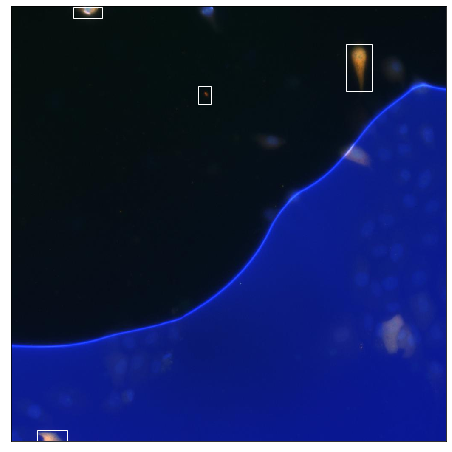

merged_191024160002_A02f275


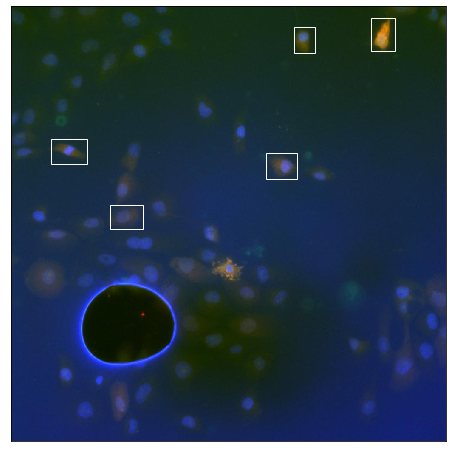

merged_191024160001_A02f80


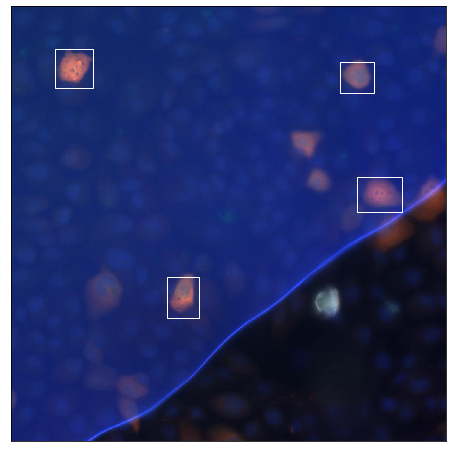

merged_191024160002_A02f226


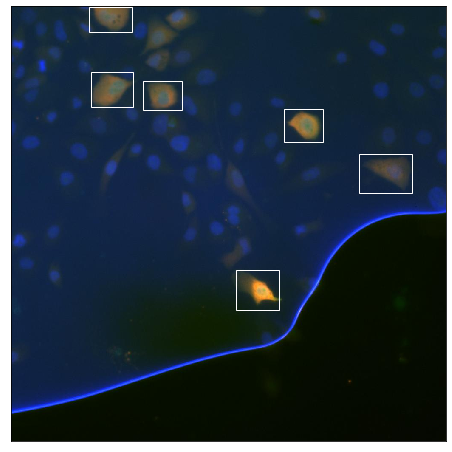

merged_191024160001_A02f99


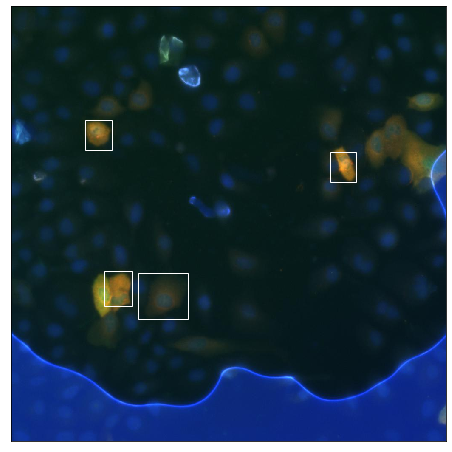

merged_191024160002_A02f249


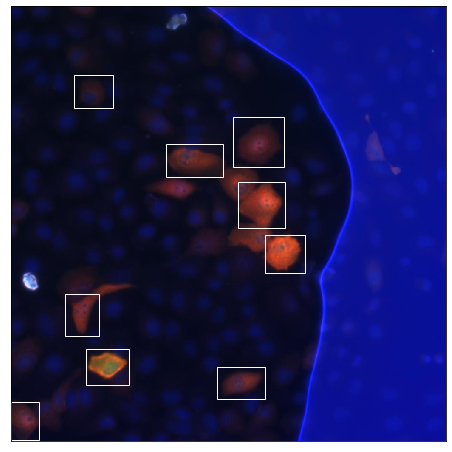

merged_191024160002_A02f297


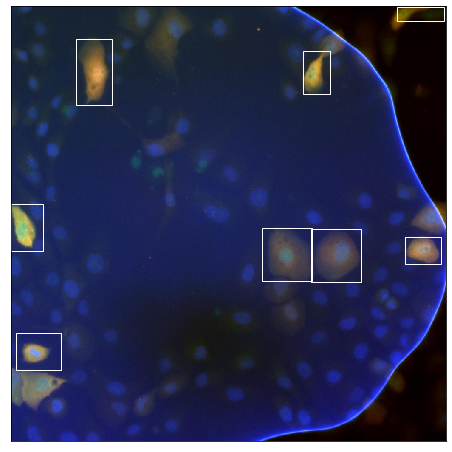

In [0]:
# show prediction results
plot_interval = 4
wrk_dir = 'input folder path' # specify working directory

for i, entry in enumerate(os.scandir(wrk_dir)):
  if i % plot_interval == 0:
    if entry.name.endswith('.jpg'):
      image = cv2.imread(entry.path, -1)
      image_ID = entry.name[:-4]
      print(image_ID)
      img_height, img_width, img_channel = image.shape
    
      bbox_df = df_predict.loc[df_predict['image_ID'] == image_ID, ['x', 'y', 'w', 'h']].reset_index(drop=True)
    
      # plot the image w/ bboxes
      fig, ax = draw_bboxes(image, img_height, img_width, bbox_df)
      plt.xticks([]), plt.yticks([]); plt.show(); plt.close()

### Crop out single cells

In [0]:
# function to show cropped single cells

def plot_cells(img_list):
  n = len(img_list)
  fig = plt.figure()
  for i in range(n):
    plt.subplot(n, 1, i+1)
    plt.imshow(img_list[i][:,:,[2,1,0]])
    plt.xticks([]), plt.yticks([])

  plt.show(); plt.close()

In [0]:
# create a new folder to host cropped cells
!mkdir Y180H_singles_RGB/
!mkdir Y180H_singles_RB/

file: merged_191024160002_A02f262
iteration: 0 



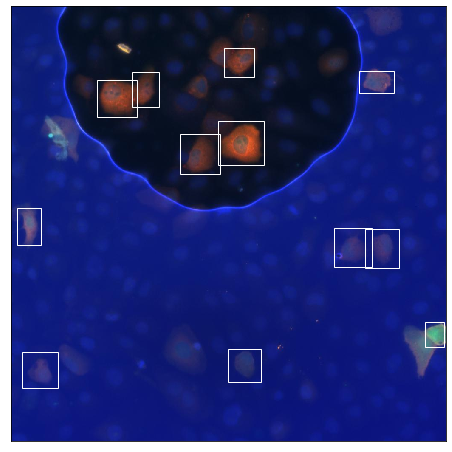

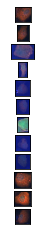

file: merged_191024160001_A02f100
iteration: 1 

file: merged_191024160002_A02f289
iteration: 2 

file: merged_191024160001_A02f119
iteration: 3 

file: merged_191024160002_A02f296
iteration: 4 

file: merged_191024160002_A02f291
iteration: 5 

file: merged_191024160002_A02f255
iteration: 6 

file: merged_191024160002_A02f230
iteration: 7 

file: merged_191024160002_A02f218
iteration: 8 

file: merged_191024160002_A02f232
iteration: 9 

file: merged_191024160002_A02f258
iteration: 10 

file: merged_191024160002_A02f275
iteration: 11 

file: merged_191024160002_A02f310
iteration: 12 

file: merged_191024160001_A02f80
iteration: 13 

file: merged_191024160002_A02f222
iteration: 14 

file: merged_191024160002_A02f250
iteration: 15 

file: merged_191024160002_A02f226
iteration: 16 

file: merged_191024160002_A02f284
iteration: 17 

file: merged_191024160002_A02f288
iteration: 18 

file: merged_191024160001_A02f99
iteration: 19 

file: merged_191024160002_A02f224
iteration: 20 



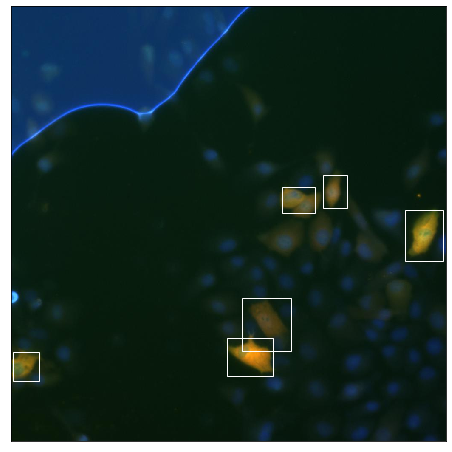

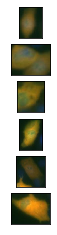

file: merged_191024160001_A02f116
iteration: 21 

file: merged_191024160001_A02f120
iteration: 22 

file: merged_191024160002_A02f249
iteration: 23 

file: merged_191024160002_A02f298
iteration: 24 

file: merged_191024160002_A02f294
iteration: 25 

file: merged_191024160002_A02f297
iteration: 26 



In [0]:
# specify source + destination folders
wrk_dir = 'input folder path' # source folder
dst_dir = 'input folder path' # images with all 3 (RGB) channels will be saved here
dst_dir_2 = 'input folder path' # images with only 2 (RB) channels will be saved here

plot_interval = 20

for i, image_ID in enumerate(df_predict['image_ID'].unique()):
  print(f'file: {image_ID}')
  print(f'iteration: {i}', '\n')
  bbox_df = df_predict.loc[df_predict['image_ID'] == image_ID, \
                           ['x', 'y', 'w', 'h']].reset_index(drop=True)

  image = cv2.imread(f'{wrk_dir}{image_ID}.jpg', -1)
  img_height, img_width, img_channel = image.shape
  
  # display images for inspection
  if i % plot_interval == 0:
    fig, ax = draw_bboxes(image, img_height, img_width, bbox_df)
    plt.xticks([]), plt.yticks([]); plt.show(); plt.close()

  # crop cells out an save
  cropped_images = []
  for j in range(len(bbox_df)):
    x = int(img_width * bbox_df.x[j])
    y = int(img_height * bbox_df.y[j])  
    w = int(img_width * bbox_df.w[j])
    h = int(img_height * bbox_df.h[j])

    # save cropped cells in RGB
    cropped_cell = image[y:y+h, x:x+w]
    cv2.imwrite(f'{dst_dir}{image_ID}_{j}.jpg', cropped_cell)
    cropped_images.append(cropped_cell)

    # remove green channel and save
    cropped_cell_rb = cropped_cell.copy()
    cropped_cell_rb[:, :, 1] = 0
    cv2.imwrite(f'{dst_dir_2}RB_{image_ID}_{j}.jpg', cropped_cell_rb)
  
  # display cropped cells for inspection
  if i % plot_interval == 0:
    plot_cells(cropped_images)


In [0]:
# how many singles cells got cropped out?
!ls folder_path | wc -l

186
